In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("data\\data.xlsx")
df = df[df["LMTD"] > 0]
df = df[df["LA Chilling Duty"] >= 0]
df["SCD (MJ/kg)"] = (0.001 * df["LA Chilling Duty"]) / df["Captured CO2 (kg/h)"]

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from joblib import dump, load

In [4]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [5]:
XA = df[["FG Temperature", "Lean Loading",'Lean Amine Temperature','L/G (kg/kg)','Flue gas CO2 cons','CO2 Capture Efficiency','LMTD','Abs Height']]
XN = df[["FG Temperature", "Lean Loading",'Lean Amine Temperature','L/G (kg/kg)','Flue gas CO2 cons','CO2 Capture Efficiency']]
y = df[["SRD (MJ/kg CO2)", "Condensor Specific Duty", "SCD (MJ/kg)"]]

In [6]:
XA_train, XA_test, y_train, y_test = train_test_split(XA, y, test_size=0.30, random_state=211)
XN_train, XN_test, y_train, y_test = train_test_split(XN, y, test_size=0.30, random_state=211)

In [7]:
max_estimators=500 # The maximum degree we would like to test
RMSE_of_models=[]

for n in range(30, max_estimators, 10):
    model = XGBRegressor(n_estimators=n, n_jobs=7, random_state=211)
    scores = cross_val_score(model, XA_train, y_train['SRD (MJ/kg CO2)'], cv=5, scoring='neg_mean_squared_error', n_jobs= -1)
    rmse = np.sqrt(np.abs(scores)).mean()
    RMSE_of_models.append(rmse)

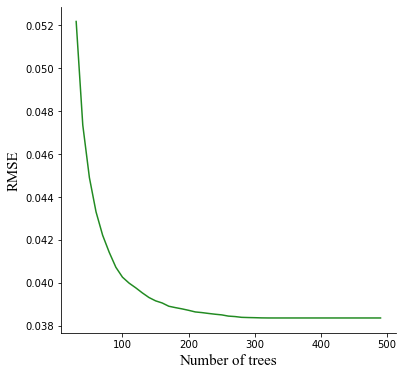

In [26]:
fig,ax=plt.subplots(figsize=(6,6))
ax.plot(range(30, max_estimators, 10),RMSE_of_models, color='forestgreen')
ax.set_xlabel('Number of trees',fontsize=15,fontname="Times New Roman")
ax.set_ylabel('RMSE',fontsize=15,fontname="Times New Roman")
ax.spines[['top', 'right']].set_visible(False)
plt.savefig('Figures\\XGHP.png', dpi=600, bbox_inches='tight')

In [9]:
param_grid = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.3],
              'max_depth': [6 , 8, 10, 20, None],
              'subsample': [0.7, 0.8, 1.0]
             }

In [10]:
xg = XGBRegressor(n_jobs=7, random_state=211, n_estimators=250)

In [11]:
xgmodel = GridSearchCV(xg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [12]:
xgmodel.fit(XA_train, y_train['SRD (MJ/kg CO2)'])

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=250,
                                    n_jobs=7, num_parallel_tree=None,
                                    predictor=None, random_state=211,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.3],
                         'max_depth': [6, 8, 10, 20, None],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [13]:
xgmodel.best_params_

{'learning_rate': 0.05, 'max_depth': 10, 'subsample': 0.8}

In [14]:
xgmodel.best_score_

-0.0008390993241194081